# Importing necessary Libraries

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Loading Train & Test Data

In [3]:
def load_diamond_data():
   train = pd.read_csv('train.csv')
   test = pd.read_csv('test.csv')
   return train, test

Train, Test = load_diamond_data()

In [28]:
#separating numerical from categorical columns
numerical_columns = ['carat','depth','table','depth_percentage','x','y','z']
cat_columns = ['cut','color','clarity']
target_column = ['price']

#adding new features based on highly correlated columns
Train['depth_percentage'] = (Train['z']*2)/ (Train['y'])+(Train['x']) #2 * z / (x + y) 
Train['volume'] = (Train['z']*Train['y']*Train['x']) #2 * z / (x + y) 
Test['depth_percentage'] = (Train['z']*2)/ (Train['y'])+(Train['x']) #2 * z / (x + y) 
Test['volume'] = (Train['z']*Train['y']*Train['x']) #2 * z / (x + y) 

#excluding null values
Train = Train[Train['depth_percentage'].notna()]
Train = Train[Train['depth_percentage']!=0]

#treating skewness of the carat feature
Train['carat'] = np.log(Train['carat'])

#splitting label from data for trainning 
Y_Train = Train[target_column]
X_train = Train.drop(target_column,axis=1)[numerical_columns+cat_columns]
Train.columns


C:\Users\Abdal\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Abdal\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Index(['Id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'x', 'y', 'z', 'depth_percentage', 'volume'],
      dtype='object')

In [5]:
print(Train.info())
print(Train[Train['depth_percentage']==0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43147 entries, 0 to 43151
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                43147 non-null  int64  
 1   carat             43147 non-null  float64
 2   cut               43147 non-null  object 
 3   color             43147 non-null  object 
 4   clarity           43147 non-null  object 
 5   depth             43147 non-null  float64
 6   table             43147 non-null  float64
 7   price             43147 non-null  int64  
 8   x                 43147 non-null  float64
 9   y                 43147 non-null  float64
 10  z                 43147 non-null  float64
 11  depth_percentage  43147 non-null  float64
 12  volume            43147 non-null  float64
dtypes: float64(8), int64(2), object(3)
memory usage: 4.6+ MB
None
Empty DataFrame
Columns: [Id, carat, cut, color, clarity, depth, table, price, x, y, z, depth_percentage, volume]
Index

seems there is no null values so that is good we will exclude rows that have dimensions as 0 

# Exploring the Data

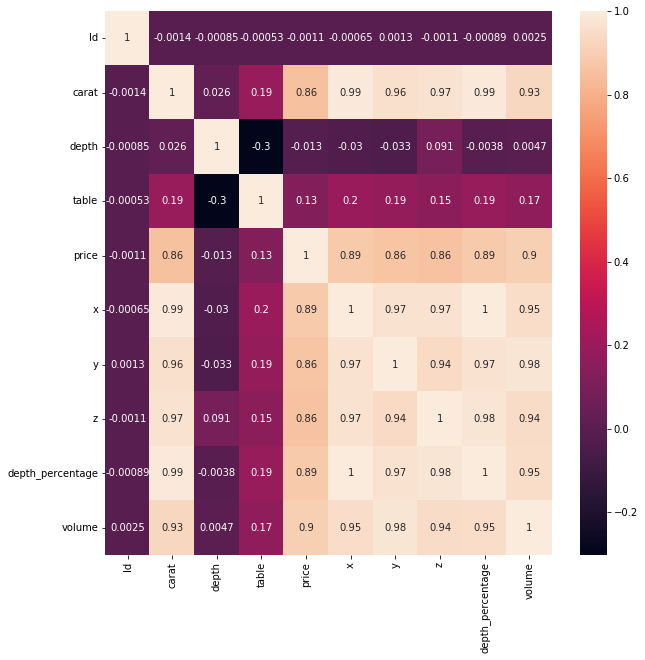

In [6]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

corr_mat=Train.corr()
sns.heatmap(corr_mat,annot=True)

from the heat map we find that the columns x,y,z,volume and depth percentage are highly correlated within themselves and with the target column (price) so we can only select one of them for our model

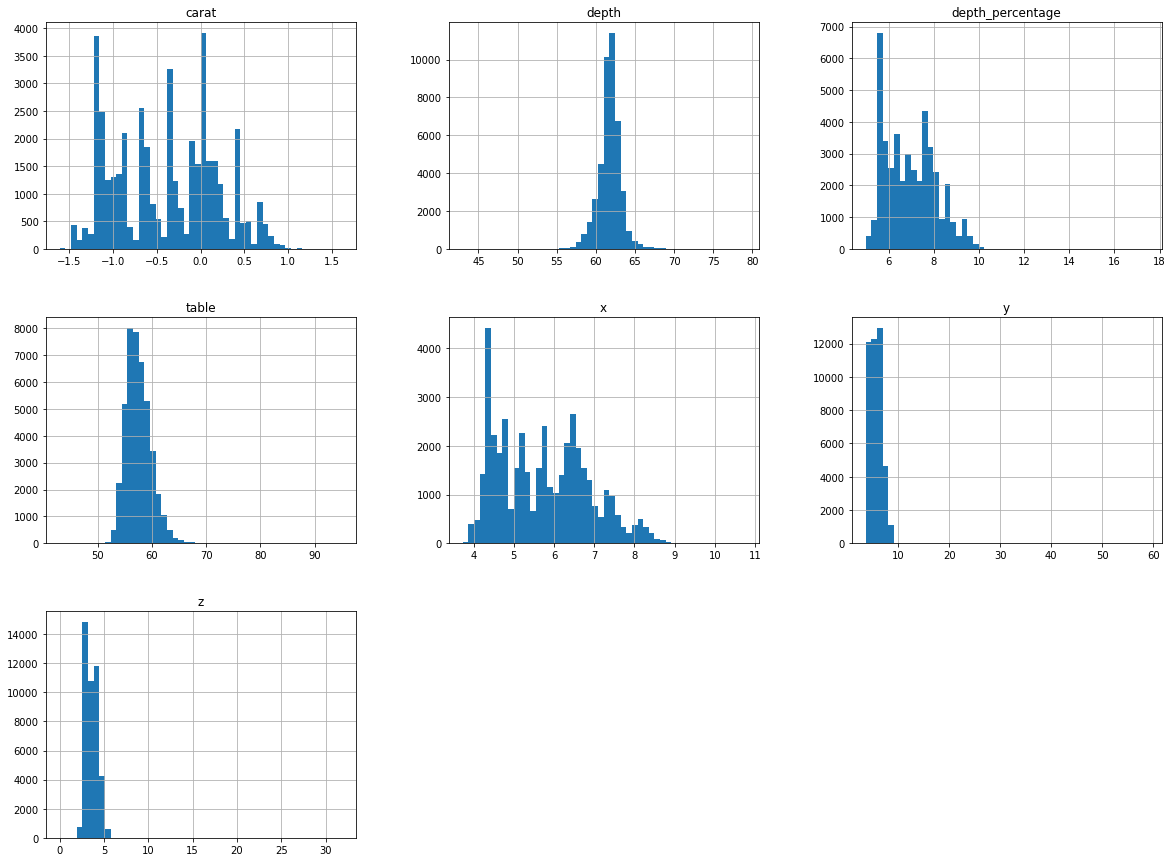

In [7]:
Train[numerical_columns].hist(figsize = (20,15),bins = 50)
plt.show()


from here we can see that some features like carat is skewed so we can treat that with the log function

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023217A03F08>,
      dtype=object)

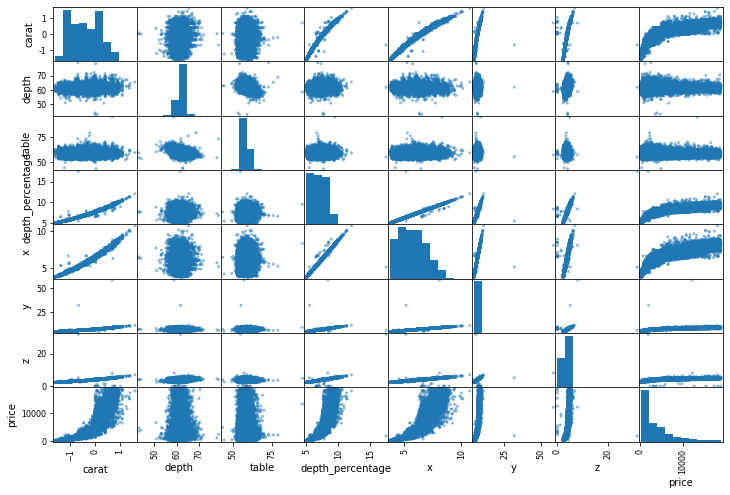

In [8]:
from pandas.plotting import scatter_matrix

scatter_matrix(Train[numerical_columns+target_column],figsize = (12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023217E6C148>,
      dtype=object)

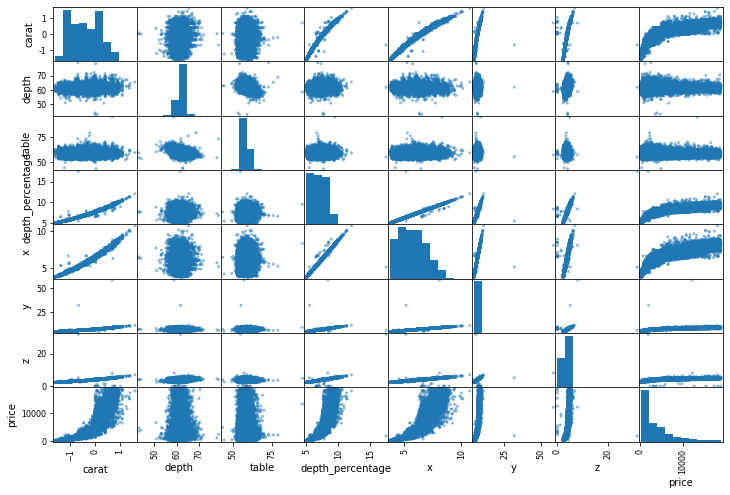

In [9]:
from pandas.plotting import scatter_matrix

scatter_matrix(Train[numerical_columns+target_column],figsize = (12,8))

seems that the log function enhanced the correlation with carat feature so we will add it to the preprocessing step

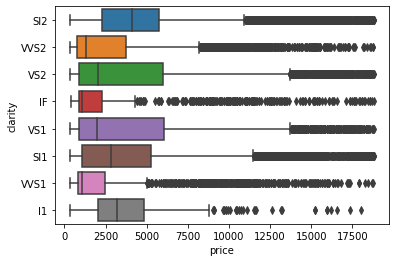

In [10]:
sns.boxplot(x="price", y="clarity",data=Train)

# Data Pre-processing & Preparing

In [11]:
from sklearn.preprocessing import OrdinalEncoder
cut_values = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_values = ['J','I','H', 'G', 'F', 'E', 'D']
clarity_values = ['I1', 'SI2', 'SI1', 'VS2', 'VS1','VVS2','VVS1','IF']
categories = [cut_values, color_values, clarity_values]

cut_encoder = OrdinalEncoder(categories=categories)




In [12]:

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler',StandardScaler()),
]

)

In [13]:
# CODE HERE
from sklearn.compose import ColumnTransformer
num_attribs = numerical_columns
cat_attribs = cat_columns

full_pipeline=ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat",cut_encoder,cat_columns)

    
])

In [14]:
X_train_prepared= full_pipeline.fit_transform(X_train[numerical_columns+cat_columns])

# Choosing a model

we will use crossvalidation with our models to prevent overfitting the data

1-GradientBoostingRegressor

In [15]:


reg = GradientBoostingRegressor(random_state=0)
#reg.fit(X_train, y_train)
scores = cross_val_score(reg, X_train_prepared, Y_Train, scoring ="neg_mean_squared_error",cv = 10)
gb_rmse_scores = np.sqrt(-scores)

C:\Users\Abdal\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abdal\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abdal\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Abdal\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

In [16]:
print("Scores: ", gb_rmse_scores)
print("Mean: ", gb_rmse_scores.mean())
print("Standard Deviation: ", gb_rmse_scores.std())

Scores:  [648.37106133 587.45951209 643.66559704 602.4162776  621.38883723
 615.87397012 616.82841889 604.28220719 590.67751811 646.0080586 ]
Mean:  617.6971458204969
Standard Deviation:  21.195058063053196


2-KNeighborsRegressor

In [18]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)

scores = cross_val_score(neigh, X_train_prepared, Y_Train, scoring ="neg_mean_squared_error",cv = 10)
neigh_rmse_scores = np.sqrt(-scores)

In [19]:
print("Scores: ", neigh_rmse_scores)
print("Mean: ", neigh_rmse_scores.mean())
print("Standard Deviation: ", neigh_rmse_scores.std())

Scores:  [742.91882527 685.00675453 746.45036387 688.0304807  720.46922836
 695.84644017 747.43352931 744.39041504 729.56783326 786.3639004 ]
Mean:  728.6477770912466
Standard Deviation:  30.249706478003716


3-RandomForestRegressor

In [22]:
forest_reg = RandomForestRegressor(random_state=42)
forest_scores = cross_val_score(forest_reg,X_train_prepared, Y_Train,scoring = "neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)

C:\Users\Abdal\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Abdal\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Abdal\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Abdal\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y wa

In [23]:

print("Scores: ", forest_rmse_scores)
print("Mean: ", forest_rmse_scores.mean())
print("Standard Deviation: ", forest_rmse_scores.std())

Scores:  [575.92382463 532.81353496 563.36262808 529.56804348 558.06382973
 541.89329111 553.75469406 535.06670618 516.98116415 564.3201413 ]
Mean:  547.1747857671983
Standard Deviation:  17.73916746856357


3-DecisionTreeRegressor

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)

dec_tree_scores = cross_val_score(tree_reg,X_train_prepared, Y_Train,scoring = "neg_mean_squared_error", cv = 10)
dec_tree_rmse_scores = np.sqrt(-dec_tree_scores)

In [25]:
print("Scores: ", dec_tree_rmse_scores)
print("Mean: ", dec_tree_rmse_scores.mean())
print("Standard Deviation: ", dec_tree_rmse_scores.std())

Scores:  [795.54576576 726.49261994 763.2320904  714.4268255  744.09801277
 720.8072951  759.33169185 753.19435206 699.93485349 740.86443229]
Mean:  741.792793914901
Standard Deviation:  26.397499241503674


seems the best performing model was random forest we will now apply the pipeline on the test data and use the selected model to predict prices

In [29]:
Test_prep = Test [numerical_columns+cat_columns].copy()

Test_prepared= full_pipeline.fit_transform(Test_prep[numerical_columns+cat_columns])


In [30]:
forest_reg = RandomForestRegressor(n_estimators= 814, min_samples_split= 6, min_samples_leaf= 1, max_features= 8, max_depth= 130, bootstrap= True,random_state=42)
forest_reg.fit(X_train_prepared,Y_Train)
Y_test = forest_reg.predict(Test_prepared)

C:\Users\Abdal\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [31]:
Test['price'] = Y_test
Test.head()
Test['price'].head()
Test[['Id','price']].to_csv("test_pred.csv", index = False)
